In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')


In [2]:
## Load data

train = pd.read_csv('/Users/peilinjiang/Desktop/Jupyter_Notebook/Practice/Titanic_data/train.csv')
test = pd.read_csv('/Users/peilinjiang/Desktop/Jupyter_Notebook/Practice/Titanic_data/test.csv')
IDtest = test["PassengerId"]

In [3]:
# Outlier detection

def detect_outliers(df, n , features):
    outlier_indices = []
    
    #iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col],25)
        
        Q3 = np.percentile(df[col],75)
        
        #Interquartile range(IQR)
        IQR = Q3-Q1
        
        #outlier step
        outlier_step = 1.5*IQR
        
        #Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col]>Q3+outlier_step)].index
        
        #append th found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    #select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k , v in outlier_indices.items() if v>n)
    
    return multiple_outliers

# detect outliers from Age, SibSp, Parch, and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age","SibSp","Parch","Fare"])

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
Outliers_to_drop

[27, 88, 159, 180, 201, 792, 324, 846, 341, 863]

In [5]:
train.loc[Outliers_to_drop]

PassengerId  Survived  Pclass                               Name     Sex  \
27            28         0       1     Fortune, Mr. Charles Alexander    male   
88            89         1       1         Fortune, Miss. Mabel Helen  female   
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
792          793         0       3            Sage, Miss. Stella Anna  female   
324          325         0       3           Sage, Mr. George John Jr    male   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
341          342         1       1     Fortune, Miss. Alice Elizabeth  female   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch    Ticket    Fare        Cabin Embarked  
27   19.0      3      2     19950  263.00  C23 C25 C27        S  
88   23.0      3      2     19950  263.00  C23 C25 C27        S  
159   NaN      8      2  CA. 2343   69.55          NaN        S  
180   NaN      8      2  CA. 2343   69.55          NaN        S  
201   NaN      8      2  CA. 2343   69.55          NaN        S  
792   NaN      8      2  CA. 2343   69.55          NaN        S  
324   NaN      8      2  CA. 2343   69.55          NaN        S  
846   NaN      8      2  CA. 2343   69.55          NaN        S  
341  24.0      3      2     19950  263.00  C23 C25 C27        S  
863   NaN      8      2  CA. 2343   69.55          NaN        S

In [6]:
#drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [7]:
##Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

#check for null vlaues
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [9]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [10]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

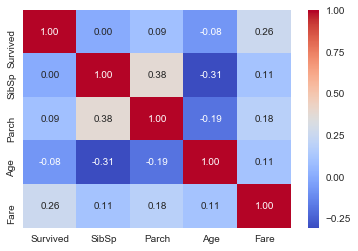

In [11]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot= True, fmt=".2f", cmap="coolwarm")

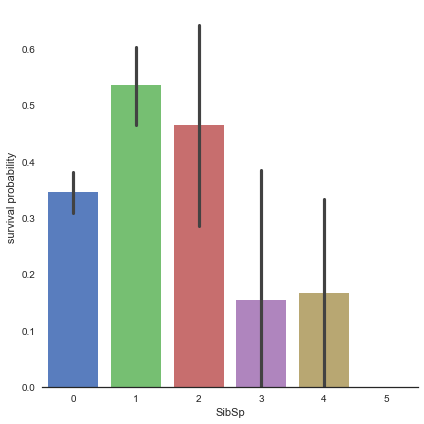

In [12]:
# Explore SibSp feature VS Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

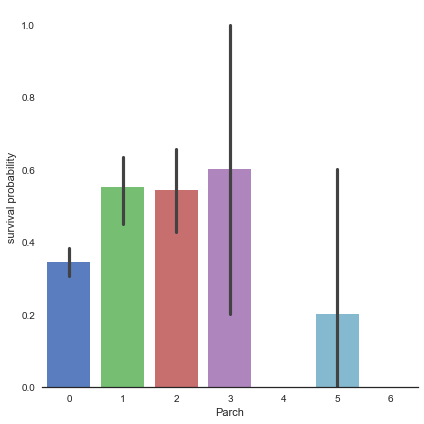

In [13]:
# Explore Parch feature vs Survived
g = sns.factorplot(x="Parch", y= 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left= True)
g = g.set_ylabels("survival probability")

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


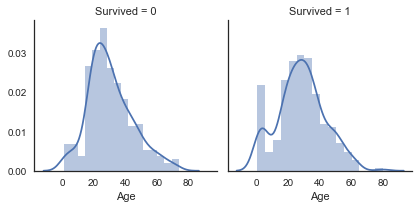

In [14]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

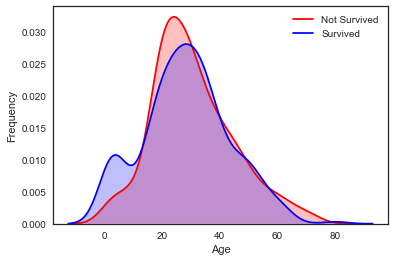

In [15]:
#Explore Age distribution
g = sns.kdeplot(train["Age"][(train["Survived"]==0) & (train["Age"].notnull())], color="Red", shade= True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1) & (train["Age"].notnull())], ax=g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g= g.legend(["Not Survived","Survived"])

In [16]:
dataset["Fare"].isnull().sum()

1

In [17]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


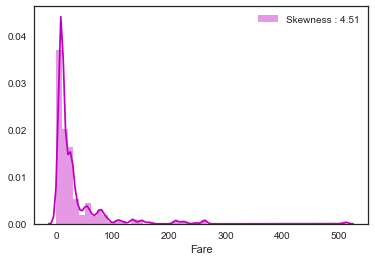

In [18]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color='m', label="Skewness : %.2f" %(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [19]:
#Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i> 0 else 0)

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


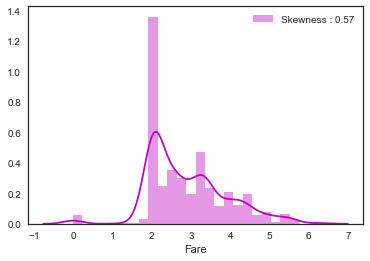

In [20]:
g = sns.distplot(dataset["Fare"], color='m', label="Skewness : %.2f" %(dataset["Fare"].skew()))
g = g.legend(loc="best")

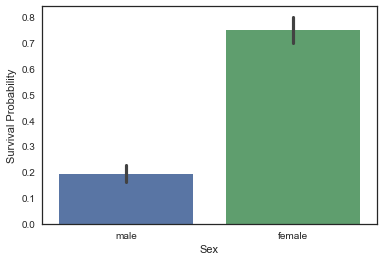

In [21]:
# Sex
g = sns.barplot(x="Sex", y = "Survived", data= train)
g = g.set_ylabel("Survival Probability")

In [22]:
train[["Sex","Survived"]].groupby('Sex').mean()

Survived
Sex             
female  0.747573
male    0.190559

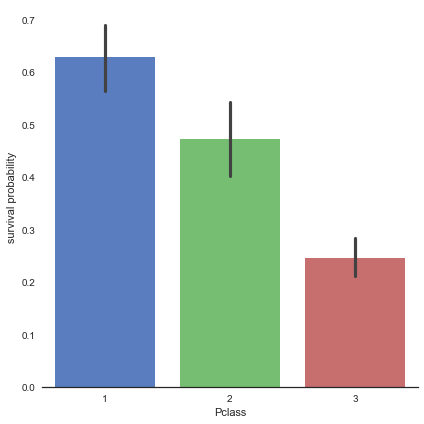

In [23]:
#Explore Pclass vs Survived
g = sns.factorplot(x="Pclass", y ="Survived", data=train, kind="bar", size = 6, palette="muted")
g.despine(left = True)
g= g.set_ylabels("survival probability")

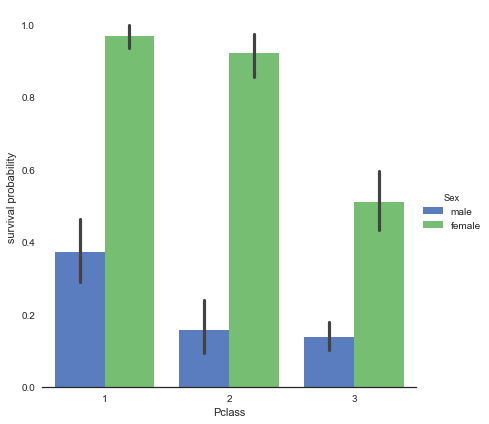

In [24]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data = train, size = 6, kind = "bar", palette="muted")
g.despine(left= True)
g = g.set_ylabels("survival probability")

In [25]:
dataset['Embarked'].isnull().sum()

2

In [26]:
# Fill Embarked nan value of datasetset with 'S' most frequent value
dataset["Embarked"] = dataset['Embarked'].fillna("S")

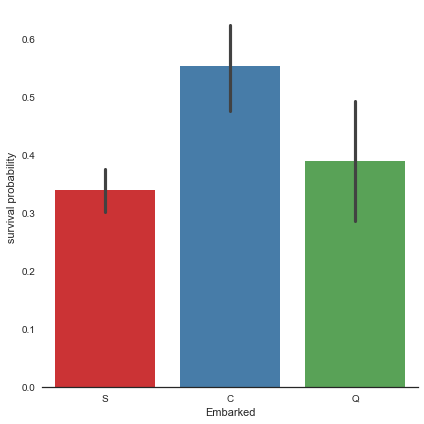

In [27]:
# Explore Embarked vs Survived
g = sns.factorplot(x="Embarked", y ="Survived", data = train, size = 6, kind = "bar", palette="Set1")
g.despine(left= True)
g = g.set_ylabels("survival probability")

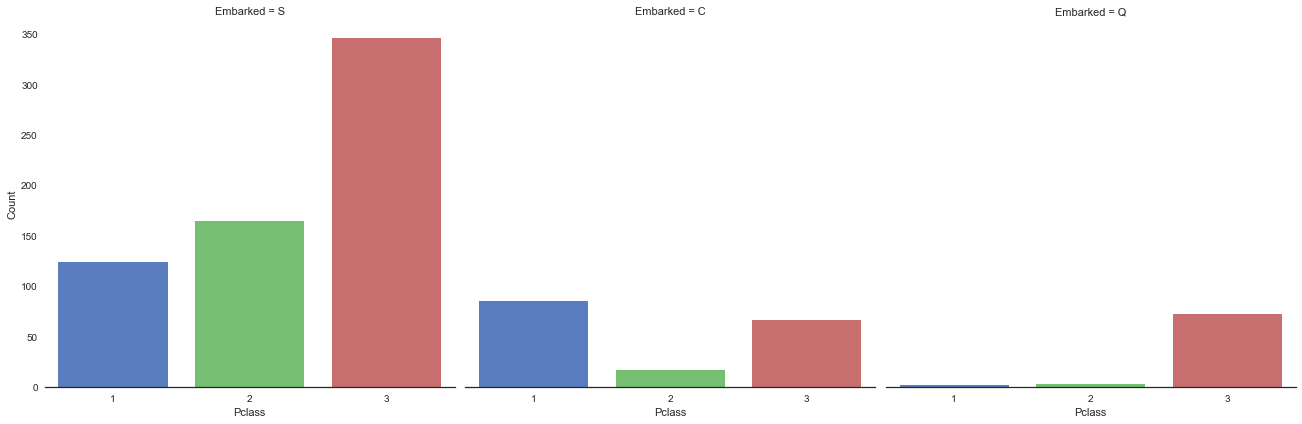

In [28]:
#Explore Pclass vs Embarked
g = sns.factorplot("Pclass", col="Embarked", data = train, size = 6, kind = "count", palette="muted")
g.despine(left = True)
g = g.set_ylabels("Count")

**Filling missing Values**

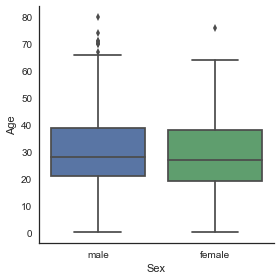

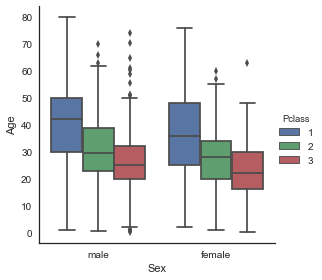

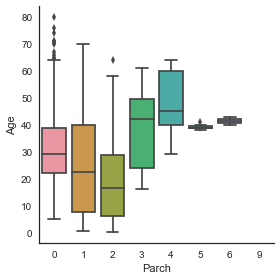

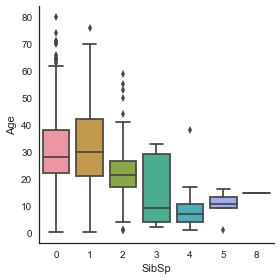

In [29]:
# Explore Age vs Sex, Parch, Pclass and SibSP
g = sns.factorplot(y = "Age", x="Sex", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x="Sex",hue="Pclass", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x="Parch", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x="SibSp", data = dataset, kind = "box")

In [30]:
#convert set into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

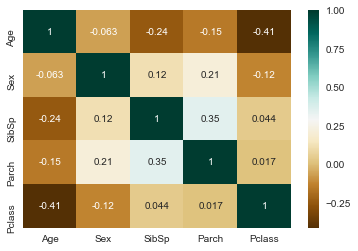

In [31]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(), cmap="BrBG", annot = True)

In [32]:
#Filling missing value of Age

## Fill age with teh median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&
                              (dataset['Parch'] == dataset.iloc[i]['Parch']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


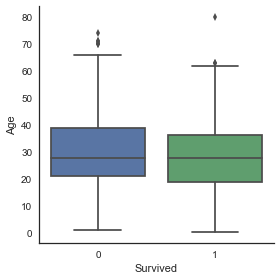

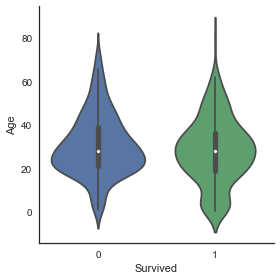

In [33]:
g = sns.factorplot(x="Survived", y = "Age", data = train, kind='box')
g = sns.factorplot(x="Survived", y = "Age", data = train, kind = 'violin')

**Feature Engineering**

In [34]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
# Get title from name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

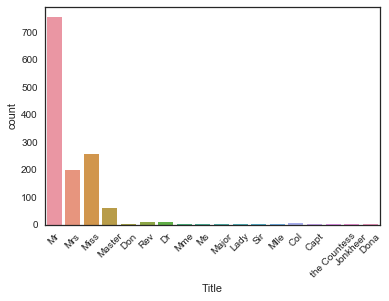

In [36]:
g = sns.countplot(x='Title', data= dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [37]:
dataset['Title'].isnull().sum()

0

In [38]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

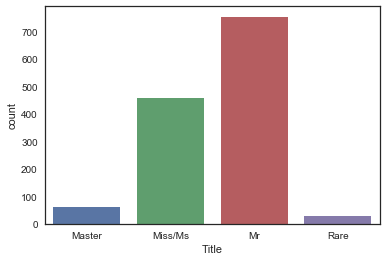

In [39]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(["Master","Miss/Ms","Mr", "Rare"])

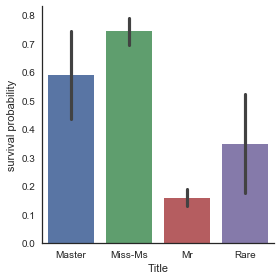

In [40]:
g = sns.factorplot(x="Title", y ="Survived", data = dataset, kind="bar")
g = g.set_xticklabels(['Master',"Miss-Ms","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [41]:
#Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp']+dataset['Parch']+1

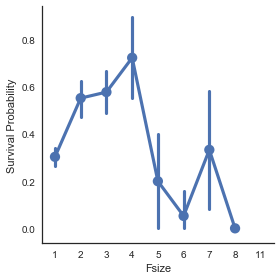

In [42]:
g = sns.factorplot(x='Fsize', y ='Survived', data = dataset)
g = g.set_ylabels('Survival Probability')

In [43]:
#create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s ==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s>= 5 else 0)

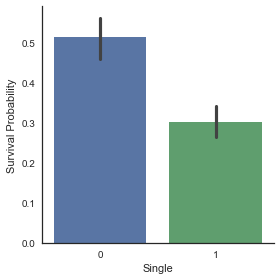

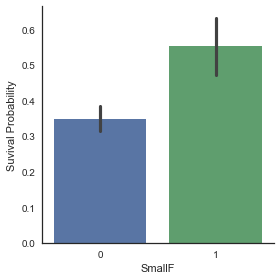

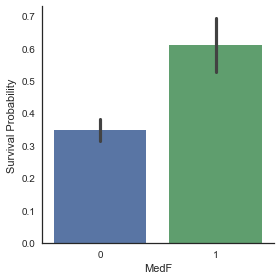

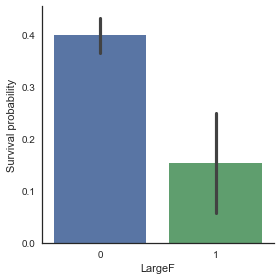

In [44]:
g = sns.factorplot(x='Single', y ='Survived', data = dataset, kind = 'bar')
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x='SmallF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Suvival Probability')
g= sns.factorplot(x= 'MedF', y = 'Survived', data = dataset, kind  = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x='LargeF', y ='Survived', data = dataset, kind = 'bar')
g = g.set_ylabels("Survival probability")

In [45]:
#Convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [46]:
dataset.head()

Age Cabin      Fare                                               Name  \
0  22.0   NaN  1.981001                            Braund, Mr. Owen Harris   
1  38.0   C85  4.266662  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2  26.0   NaN  2.070022                             Heikkinen, Miss. Laina   
3  35.0  C123  3.972177       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4  35.0   NaN  2.085672                           Allen, Mr. William Henry   

   Parch  PassengerId  Pclass  Sex  SibSp  Survived  ...  SmallF  MedF  \
0      0            1       3    0      1       0.0  ...       1     0   
1      0            2       1    1      1       1.0  ...       1     0   
2      0            3       3    1      0       1.0  ...       0     0   
3      0            4       1    1      1       1.0  ...       1     0   
4      0            5       3    0      0       0.0  ...       0     0   

   LargeF  Title_0  Title_1  Title_2  Title_3  Em_C  Em_Q  Em_S  
0       0        0        0        1        0     0     0     1  
1       0        0        1        0        0     1     0     0  
2       0        0        1        0        0     0     0     1  
3       0        0        1        0        0     0     0     1  
4       0        0        0        1        0     0     0     1  

[5 rows x 23 columns]

In [47]:
#drop Name variable
dataset.drop(['Name'], axis=1, inplace=True)

In [48]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].isnull().sum()

1007

In [51]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

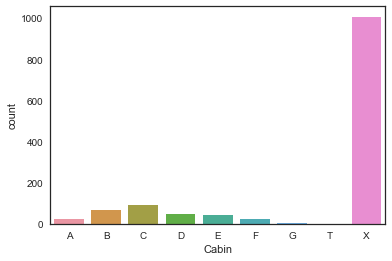

In [53]:
g = sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

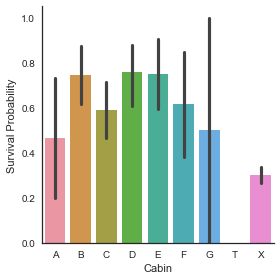

In [54]:
g= sns.factorplot(y='Survived', x= 'Cabin', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g =g.set_ylabels("Survival Probability")

In [55]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix ='Cabin')

In [56]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [57]:
dataset['Ticket'].value_counts()

1601                 8
CA 2144              8
347082               7
347077               7
3101295              7
PC 17608             7
S.O.C. 14879         7
382652               6
113781               6
347088               6
PC 17757             5
220845               5
4133                 5
W./C. 6608           5
113503               5
16966                5
349909               5
17421                4
SC/Paris 2123        4
24160                4
PC 17755             4
113760               4
LINE                 4
CA. 2343             4
C.A. 33112           4
36928                4
PC 17760             4
2666                 4
C.A. 2315            4
12749                4
                    ..
STON/O 2. 3101268    1
C.A. 24579           1
347062               1
323951               1
29011                1
248726               1
347078               1
3101276              1
347079               1
347074               1
347075               1
347076               1
C.A. 18723 

In [58]:
# Treat Ticket by extracting the ticket prefix, whne there is no prefix it return X
Ticket = []

for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append('X')
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset['Ticket'].value_counts()

X          954
PC          92
CA          61
A5          28
SOTONOQ     24
WC          15
STONO       14
SCPARIS     14
A4          10
FCC          9
C            8
SOC          8
STONO2       7
SOPP         7
SCAH         5
SCParis      5
LINE         4
WEP          4
PP           4
FC           3
SOTONO2      3
SC           2
SCA4         2
SWPP         2
PPP          2
SCOW         1
SP           1
SOP          1
SCA3         1
STONOQ       1
CASOTON      1
LP           1
A            1
Fa           1
AQ4          1
AQ3          1
AS           1
Name: Ticket, dtype: int64

In [60]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [61]:
dataset['Pclass'].head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [62]:
#Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [63]:
#Drop useless variables
dataset.drop(['PassengerId'], axis=1, inplace=True)

In [64]:
dataset.head()

Age      Fare  Parch  Sex  SibSp  Survived  Fsize  Single  SmallF  MedF  \
0  22.0  1.981001      0    0      1       0.0      2       0       1     0   
1  38.0  4.266662      0    1      1       1.0      2       0       1     0   
2  26.0  2.070022      0    1      0       1.0      1       1       0     0   
3  35.0  3.972177      0    1      1       1.0      2       0       1     0   
4  35.0  2.085672      0    0      0       0.0      1       1       0     0   

   ...   T_STONO  T_STONO2  T_STONOQ  T_SWPP  T_WC  T_WEP  T_X  Pc_1  Pc_2  \
0  ...         0         0         0       0     0      0    0     0     0   
1  ...         0         0         0       0     0      0    0     1     0   
2  ...         0         1         0       0     0      0    0     0     0   
3  ...         0         0         0       0     0      0    1     1     0   
4  ...         0         0         0       0     0      0    1     0     0   

   Pc_3  
0     1  
1     0  
2     1  
3     0  
4     1  

[5 rows x 67 columns]

In [65]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(['Survived'], axis = 1, inplace = True)

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [66]:
### Separate train features and label

train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']
X_train = train.drop(['Survived'], axis = 1)

/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Simple modeling**

In [67]:
# Cross validate model with KFold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [68]:
random_state = 42

classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state= random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [69]:
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs=-1))
    
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())


/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/peilinjiang/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variabl

In [70]:
cv_res = pd.DataFrame({'CrossValMeans':cv_means, "CrossValerrors": cv_std, "Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

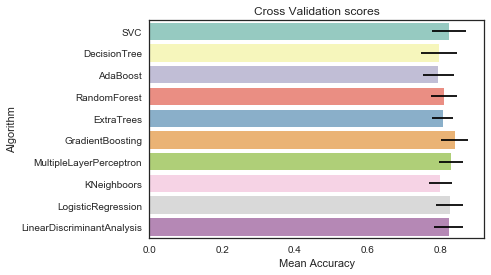

In [71]:
g = sns.barplot('CrossValMeans',"Algorithm", data = cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title('Cross Validation scores')

In [72]:
#Adaboost
DTC= DecisionTreeClassifier()
estimators = np.random.randint(1,21, size=20)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.7, 1.1, 1.5]
adaDTC = AdaBoostClassifier(DTC, random_state= random_state)
ada_param_grid = {"base_estimator__criterion":["gini","entropy"],
                 "base_estimator__splitter": ["best","random"],
                 "algorithm":["SAMME","SAMME.R"],
                 "n_estimators":estimators,
                 "learning_rate":learning_rate}

In [73]:
grid_search_cv = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv= kfold, scoring = 'accuracy', n_jobs =-1, verbose = 2)

In [74]:
grid_search_cv.fit(X_train, Y_train)

Fitting 10 folds for each of 1280 candidates, totalling 12800 fits
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_e

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, b

[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.0001, a

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.3s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001

[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMM

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SA

[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:    8.1s


[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estim

[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algori

[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, b

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_est

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, ba

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, bas

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__sp

[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator_

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estim

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SA

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, alg

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=

[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_e

[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, ba

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter

[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_est

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__s

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=b

[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:   28.6s


[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=

[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__s

[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__s

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_esti

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__sp

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estim

[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__spli

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__s

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitt

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, bas

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estima

[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_esti

[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, bas

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitt

[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__s

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_e

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estima

[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__spli

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__s

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_esti

[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitt

[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, ba

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rat

[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_ra

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.00

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001,

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, alg

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.00

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SA

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAM

[Parallel(n_jobs=-1)]: Done 1849 tasks      | elapsed:  1.0min


[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.001, algorithm

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algor

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=S

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.001, algo

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algor

[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, bas

[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.01,

[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, alg

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SA

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMM

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimat

[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_esti

[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, bas

[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=

[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algori

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estima

[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_est

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, bas

[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMM

[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME, bas

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMM

[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estim

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, bas

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorit

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_esti

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algori

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1,

[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAM

[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=S

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algori

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=S

[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, bas

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SA

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMM

[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=S

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, bas

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_es

[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algori

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.

[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate

[Parallel(n_jobs=-1)]: Done 3264 tasks      | elapsed:  1.7min


[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=ent

[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, al

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_

[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learnin

[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001,

[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learnin

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, 

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.

[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorith

[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=20, base_estimator__criterion=entropy, learnin

[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.01, algor

[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorith

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, al

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algo

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algo

[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, alg

[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, a

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0

[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, al

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, b

[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, 

[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, al

[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME,

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algo

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, 

[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=S

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, a

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, b

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, ba

[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME,

[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=1

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMM

[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMM

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algo

[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME

[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, b

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, 

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, le

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criteri

[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entro

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entr

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, 

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learn

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_r

[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion

[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=14, base_estimator__criterion=entropy, le

[Parallel(n_jobs=-1)]: Done 5089 tasks      | elapsed:  2.8min


[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criter

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion

[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criteri

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, l

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, le

[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=

[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=entr

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=ent

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algor

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_

[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learnin

[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=entropy, 

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, lear

[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, l

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, lea

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_

[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, lear

[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, l

[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learn

[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, al

[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=ent

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_

[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learn

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, l

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learni

[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, l

[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learnin

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algor

[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, a

[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=14, base_estimator__criterion=entropy, l

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning

[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, alg

[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algor

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algor

[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, lear

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algo

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, l

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_ra

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algor

[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learnin

[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, lear

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, alg

[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=gini, learning_r

[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, lear

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SA

[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=S

[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_ra

[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_ra

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_ra

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, b

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algori

[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R

[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME

[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, b

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_esti

[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=S

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, b

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estim

[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SA

[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, b

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_esti

[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAM

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, b

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorit

[Parallel(n_jobs=-1)]: Done 7314 tasks      | elapsed:  4.0min


[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm

[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=

[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algori

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7,

[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SA

[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, b

[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.3s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.7, algorithm=S

[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, b

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estim

[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estim

[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=1.1, algorithm

[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, b

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SA

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algor

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMM

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAM

[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_est

[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, b

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base

[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, ba

[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMM

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rat

[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, lear

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_r

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criter

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learn

[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=gini, lear

[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.0

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rat

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, 

[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator_

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_ra

[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.01, al

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.01

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, al

[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.01, algo

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.01

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMM

[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.1, 

[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAM

[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algori

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.

[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algori

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAM

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.3, 

[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=0.3, algorithm

[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.3, algori

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAM

[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.3, algori

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMM

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMM

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=0.7, algori

[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.3s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_ra

[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=0.

[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=0.7, algori

[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1,

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, 

[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.1, algorithm=S

[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.1, algori

[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.

[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algori

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate

[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMM

[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=9, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=9, base_estimator__criterion=gini, learning_rate=1

[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=14, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=20, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=gini, learning_ra

[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=gini, learning_rate=1

[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=gini, learning_rate=1.5

[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=gini, learning_rate=1.5, algori

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, le

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criter

[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criter

[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator_

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy

[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator_

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entrop

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entr

[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learni

[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=14, base_estimator__criter

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learn

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entr

[Parallel(n_jobs=-1)]: Done 9949 tasks      | elapsed:  5.4min


[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterio

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, l

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, le

[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy,

[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.3s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=entro

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, 

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=ent

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_

[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learnin

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=entropy, lear

[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=entropy, l

[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, le

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_

[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=entropy, learn

[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, l

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.3, a

[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, alg

[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, l

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algo

[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algor

[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learnin

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, l

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learni

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning

[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learni

[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.3s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.3s
[CV]  n_estimators=14, base_estimator__criterion=entropy, 

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, al

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learni

[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=11, base_estimator__criterion=entropy, l

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_

[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, al

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, l

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.2s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learn

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, l

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=best, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entro

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimato

[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__crit

[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, b

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=13, base_estimator__crit

[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=12, base_e

[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.0001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=11, 

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator_

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entr

[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=ent

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criter

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimat

[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterio

[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.001, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criter

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criteri

[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, l

[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=20, base_estimator

[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=ent

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criter

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.01, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator_

[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=ent

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entr

[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=8, base_estimator__criterion=ent

[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, l

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=

[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learni

[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criter

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entr

[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=9, base_estimator__criterion=entr

[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, le

[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criter

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.3, al

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__crite

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.3, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_r

[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, lear

[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=20, base_estimator__criter

[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=ent

[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=ent

[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=0.7, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, l

[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_r

[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_r

[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=8, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=20, base_estimator__criterion

[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, l

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estimator__criterion=en

[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, l

[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.1, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=6, base_estima

[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=6, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=1, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=1, base_estimator__criterion=entr

[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=9, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=18, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=18, base_estimator__criterion

[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV] n_estimators=14, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=20, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=20, base_estimator__criterion=entropy, l

[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=17, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.2s
[CV]  n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.0s
[CV] n_estimators=4, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=4, base_estimator__criterion=entropy, learnin

[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=13, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=12, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=5, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=5, base_estimator__criterion=entropy, learnin

[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV] n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=10, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random 
[CV]  n_estimators=11, base_estimator__criterion=entropy, learning_rate=1.5, algorithm=SAMME.R, base_estimator__splitter=random, total=   0.1s
[CV] n_estimators=11, base_estimator__criter

[Parallel(n_jobs=-1)]: Done 12800 out of 12800 | elapsed:  6.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 6,  1,  6,  1,  4,  9, 18,  8, 20, 14, 17, 13,  4, 13,  6,  5, 12,
       10, 11, 10]), 'base_estimator__criterion': ['gini', 'entropy'], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.7, 1.1, 1.5], 'algorithm': ['SAMME', 'SAMME.R'], 'base_estimator__splitter': ['best', 'random']},
       pre_dispatch=

In [75]:
ada_best = grid_search_cv.best_estimator_

In [76]:
ada_best

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=20, random_state=42)

In [77]:
grid_search_cv.best_score_

0.8229284903518729

In [78]:
#ExtraTrees
ExtC = ExtraTreesClassifier()

# Search grid for optimal parameters
ex_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

In [79]:
gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=2)

In [80]:
gsExtC.fit(X_train, Y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, tot

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   0.8s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   0.8s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   2.3s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   2.2s
[CV] bootstrap=False, min_samples_lea

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s


[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   2.1s
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   2.2s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   2.0s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.9s
[CV] bootstrap=False, min_samples_le

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_lea

[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.4s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.4s
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.4s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estim

[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.2s


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.4s
[CV] bootstrap=False, min_sam

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_lea

[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.8s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.8s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estim

[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimat

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.4s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samp

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.4s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.4s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_s

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=10, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_sam

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samp

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samp

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samp

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV]  bootstrap=False, 

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, m

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=10, max_depth=None, total=   1.1s


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [False], 'min_samples_leaf': [1, 3, 10], 'n_estimators': [100, 300], 'min_samples_split': [2, 3, 10], 'criterion': ['gini'], 'max_features': [1, 3, 10], 'max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [81]:
ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

0.8286038592508513

In [82]:
#RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth":[None],
                 "max_features":[1,3,10],
                 "min_samples_split":[2,3,10],
                 "min_samples_leaf":[1,3,10],
                 "bootstrap":[False],
                 "n_estimators":[100,300],
                 "criterion":["gini"]
                }

In [83]:
gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv = kfold, scoring='accuracy', n_jobs=-1, verbose=2)

In [84]:
gsRFC.fit(X_train,Y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, tot

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_lea

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s


[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.8s
[CV] bootstrap=False, min_samples_le

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_lea

[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estim

[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=2, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.1s


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=1, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=1, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_sam

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_lea

[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.8s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estim

[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimat

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_samples_

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samp

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=3, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=3, criterion=gini, min_samples_split=10, max_depth=None, total=   0.5s
[CV] bootstrap=False, min_s

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=3, criterion=gini, min_samples_split=10, max_depth=None, total=   1.5s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_sam

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.8s
[CV] bootstrap=False, min_samp

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=300, max_features=10, criterion=gini, min_samples_split=10, max_depth=None, total=   1.8s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.6s
[CV] bootstrap=False, min_sam

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   1.8s
[CV] bootstrap=False, min_samp

[CV]  bootstrap=False, min_samples_leaf=3, n_estimators=300, max_features=10, criterion=gini, min_samples_split=10, max_depth=None, total=   2.1s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.9s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.9s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=2, max_depth=None, total=   0.8s
[CV] bootstrap=False, m

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.9s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.8s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=100, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   0.7s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=3, max_depth=None, total=   2.0s
[CV] bootstrap=False, m

[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=10, max_depth=None, total=   1.6s
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=10, max_depth=None, total=   1.1s
[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=300, max_features=10, criterion=gini, min_samples_split=10, max_depth=None, total=   1.1s


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [False], 'min_samples_leaf': [1, 3, 10], 'n_estimators': [100, 300], 'min_samples_split': [2, 3, 10], 'criterion': ['gini'], 'max_features': [1, 3, 10], 'max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [85]:
gsRFC.best_score_

0.8354143019296254

In [86]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss':['deviance'],
                'n_estimators':[100,200,300],
                'learning_rate':[0.1, 0.05, 0.01],
                'max_depth':[4,8],
                'min_samples_leaf':[100, 150],
                'max_features':[0.3, 0.1]}

In [87]:
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=2)

In [88]:
gsGBC.fit(X_train,Y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4 
[CV] loss=de

[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=4, total=   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150

[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.4s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100

[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150

[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=8, total=   0.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100

[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100

[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=8, total=   0.3s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=150,

[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.2s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.0

[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.0

[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:   19.0s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples

[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4, total=   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_

[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_

[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=8, total=   0.3s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=8, total=   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_

[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=150, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_

[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=4, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.3, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_

[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=300, max_features=0.3, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.3, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_

[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4, total=   0.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=4, total=   0.4s
[CV] loss=deviance, learning_rate=0.01, min_samples_

[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=300, max_features=0.1, max_depth=4, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.3, max_depth=8, total=   0.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples

[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8, total=   0.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.3, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=100, max_features=0.3, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_

[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=200, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=100, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_

[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=100, n_estimators=300, max_features=0.1, max_depth=8, total=   0.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8, total=   0.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=150, n_estimators=200, max_features=0.1, max_depth=8, total=   0.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_

[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   42.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.1, 0.05, 0.01], 'min_samples_leaf': [100, 150], 'n_estimators': [100, 200, 300], 'max_features': [0.3, 0.1], 'max_depth': [4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [89]:
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

0.8354143019296254

In [90]:
#SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                 'gamma':[0.001,0.01,0.1,1],
                 'C': [1,5,10,15,20,30]}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=2)

In [91]:
gsSVMC.fit(X_train, Y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   0.4s
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   0.4s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   0.4s
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   0.4s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   0.3s
[CV] kernel=rb

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s


[CV] kernel=rbf, C=1, gamma=1 ........................................
[CV] ......................... kernel=rbf, C=1, gamma=1, total=   0.5s
[CV] kernel=rbf, C=1, gamma=1 ........................................
[CV] ......................... kernel=rbf, C=1, gamma=1, total=   0.5s
[CV] kernel=rbf, C=5, gamma=0.001 ....................................
[CV] ......................... kernel=rbf, C=1, gamma=1, total=   0.5s
[CV] kernel=rbf, C=5, gamma=0.001 ....................................
[CV] ......................... kernel=rbf, C=1, gamma=1, total=   0.5s
[CV] kernel=rbf, C=5, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=5, gamma=0.001, total=   0.3s
[CV] kernel=rbf, C=5, gamma=0.001 ....................................
[CV] ......................... kernel=rbf, C=1, gamma=1, total=   0.6s
[CV] kernel=rbf, C=5, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=5, gamma=0.001, total=   0.3s
[CV] k

[CV] kernel=rbf, C=10, gamma=0.01 ....................................
[CV] ..................... kernel=rbf, C=10, gamma=0.01, total=   0.4s
[CV] kernel=rbf, C=10, gamma=0.01 ....................................
[CV] ..................... kernel=rbf, C=10, gamma=0.01, total=   0.4s
[CV] kernel=rbf, C=10, gamma=0.01 ....................................
[CV] ..................... kernel=rbf, C=10, gamma=0.01, total=   0.4s
[CV] ..................... kernel=rbf, C=10, gamma=0.01, total=   0.4s
[CV] kernel=rbf, C=10, gamma=0.01 ....................................
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ..................... kernel=rbf, C=10, gamma=0.01, total=   0.4s
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ..................... kernel=rbf, C=10, gamma=0.01, total=   0.4s
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ..................... kernel=rbf, C=10, gamma=0.01, total=   0.3s
[CV] k

[CV] kernel=rbf, C=15, gamma=1 .......................................
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.4s
[CV] kernel=rbf, C=15, gamma=1 .......................................
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.4s
[CV] kernel=rbf, C=15, gamma=1 .......................................
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.4s
[CV] kernel=rbf, C=15, gamma=1 .......................................


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.0s


[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.5s
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.5s
[CV] kernel=rbf, C=15, gamma=1 .......................................
[CV] kernel=rbf, C=15, gamma=1 .......................................
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.5s
[CV] kernel=rbf, C=20, gamma=0.001 ...................................
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.5s
[CV] kernel=rbf, C=20, gamma=0.001 ...................................
[CV] .................... kernel=rbf, C=20, gamma=0.001, total=   0.3s
[CV] kernel=rbf, C=20, gamma=0.001 ...................................
[CV] .................... kernel=rbf, C=20, gamma=0.001, total=   0.2s
[CV] kernel=rbf, C=20, gamma=0.001 ...................................
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.5s
[CV] ........................ kernel=rbf, C=15, gamma=1, total=   0.5s
[CV] k

[CV] ..................... kernel=rbf, C=30, gamma=0.01, total=   0.3s
[CV] kernel=rbf, C=30, gamma=0.01 ....................................
[CV] ..................... kernel=rbf, C=30, gamma=0.01, total=   0.3s
[CV] kernel=rbf, C=30, gamma=0.01 ....................................
[CV] ..................... kernel=rbf, C=30, gamma=0.01, total=   0.4s
[CV] kernel=rbf, C=30, gamma=0.01 ....................................
[CV] ..................... kernel=rbf, C=30, gamma=0.01, total=   0.5s
[CV] kernel=rbf, C=30, gamma=0.01 ....................................
[CV] ..................... kernel=rbf, C=30, gamma=0.01, total=   0.5s
[CV] kernel=rbf, C=30, gamma=0.1 .....................................
[CV] ..................... kernel=rbf, C=30, gamma=0.01, total=   0.5s
[CV] kernel=rbf, C=30, gamma=0.1 .....................................
[CV] ..................... kernel=rbf, C=30, gamma=0.01, total=   0.4s
[CV] kernel=rbf, C=30, gamma=0.1 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   28.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'C': [1, 5, 10, 15, 20, 30], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [92]:
SVM_best = gsSVMC.best_estimator_
gsSVMC.best_score_

0.8354143019296254

**Plot learning curves**

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy

In [100]:
def plot_learning_curve(estimator, title, X,y, ylim=None, cv = None, n_jobs=-1, train_sizes=np.linspace(.1,1.0,5)):
    #Generate a simple plot of the test and training learning curve
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Trainig examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X,y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_means = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_means = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_means- train_scores_std, train_scores_means+train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_means-test_scores_std, test_scores_means+test_scores_std, alpha=0.1, color = 'g')
    plt.plot(train_sizes, train_scores_means, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_means, 'o-', color='g', label = 'Cross-validation score')
    
    plt.legend(loc='best')
    
    return plt

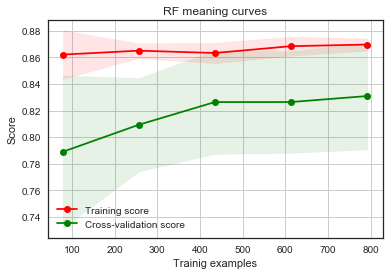

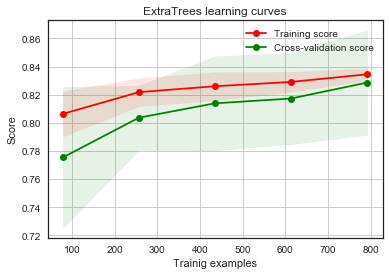

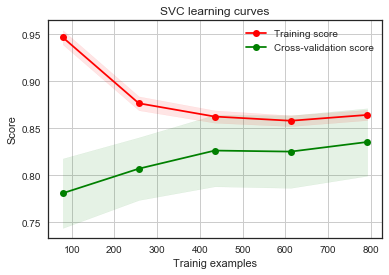

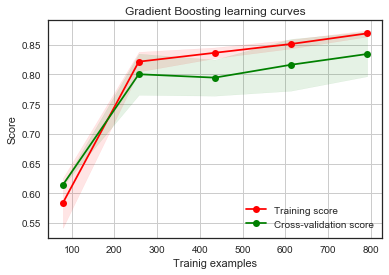

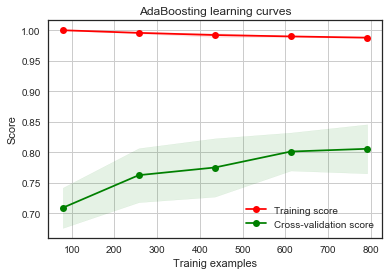

In [102]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF meaning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves", X_train, Y_train, cv=kfold)

g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"Gradient Boosting learning curves", X_train, Y_train, cv=kfold)

g = plot_learning_curve(grid_search_cv.best_estimator_,"AdaBoosting learning curves", X_train, Y_train, cv=kfold)



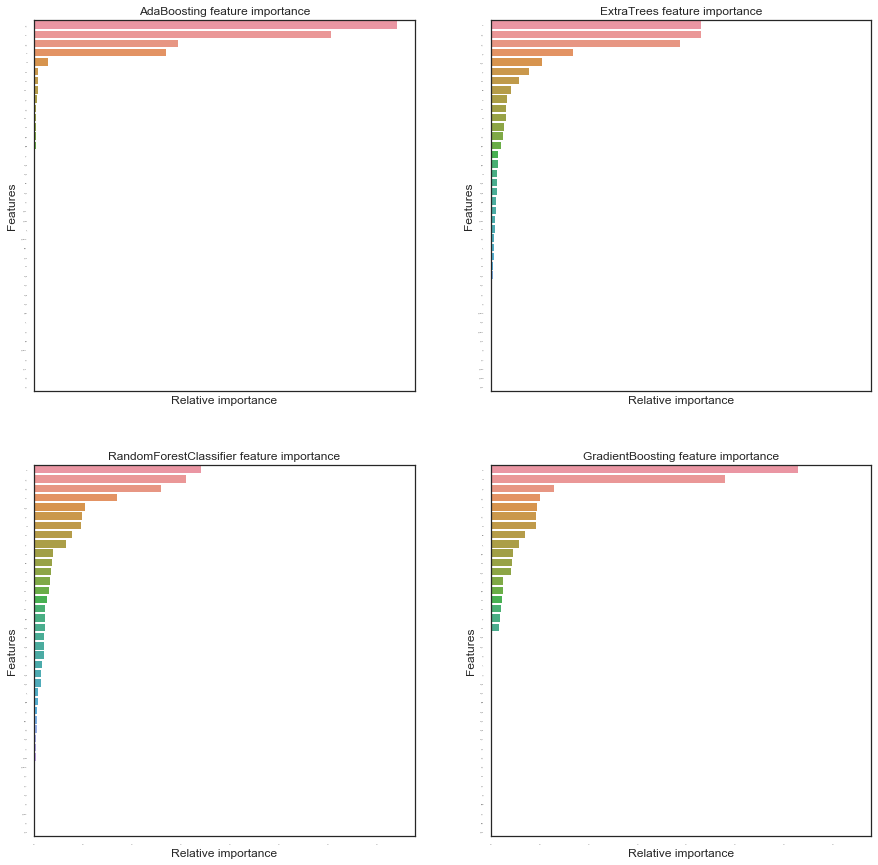

In [106]:
nrows = ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols = ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best),('ExtraTrees',ExtC_best),('RandomForestClassifier',gsRFC.best_estimator_),
                    ('GradientBoosting',GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]

        g = sns.barplot(y=X_train.columns[indices][:40], x = classifier.feature_importances_[indices][:40]
                       , orient = 'h', ax= axes[row][col])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=0)
        g.set_title(name+" feature importance")

        nclassifier +=1
    
    